- forward pass
  - model is fed input data and a measure of the error is evaluated by comparing the reuslting outputs to the ground truth
- backward pass
  - in order to optimize the model weights, the change in error following a unit change in weights (gradient) is computed using the chain rule for the derivative of a composite function
  - value of the weights is updated in the direction that leads to a decrease in error

In [8]:
import torch
import matplotlib.pyplot as plt

In [134]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'TEMPERATURE (CELSIUS)')

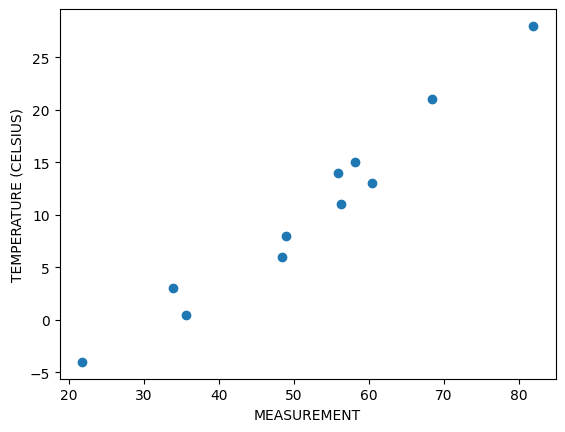

In [15]:
plt.plot(t_u, t_c, marker = 'o', linestyle = 'None')
plt.xlabel('MEASUREMENT')
plt.ylabel('TEMPERATURE (CELSIUS)')

- loss function
  - a function that computes a single numerical value that the learning process will attempt to minimize
  - typically involves taking the difference between the desired outputs for some training samples and the outputs are acutally produced by the model when fed those samples
  - prioritize which errors to fix from our training samples so that our parameter updates result in adjustments to the outputs for the highly weighted samples instead of changes to some other samples' output that had a smaller loss

In [81]:
def model(t_u, w, b):
	return w * t_u + b

In [82]:
# Mean Square Loss
def loss_fn(t_p, t_c):
	squared_diffs = (t_p - t_c) ** 2
	return squared_diffs.mean()

In [78]:
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [20]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

  ## Broadcasting
  - For each index dimension, counted from the back, if one of the operands is size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension
  - If both sizes are greater than 1, they must be the same, and natural matching is used
  - If one of the tensors has more index dimensions than the other, the entirety of the other tensor will be used for each entry along these dimensions

In [36]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

In [24]:
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a) .shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [37]:
print(y)

tensor([[1.],
        [1.],
        [1.]])


In [38]:
print(z)

tensor([[1., 1., 1.]])


In [39]:
print(y+z)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])


In [45]:
# Value depends on the shape of the loss as a function of w and b
delta = 0.1

# If the change is negative we need to increase w to minimize the loss
# whereas if the change is positive we need to decrease w
loss_rate_of_change_w = \
	(loss_fn(model(t_u, w + delta, b), t_c) -
	loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [41]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [44]:
loss_rate_of_change_b = \
	(loss_fn(model(t_u, w, b + delta), t_c) -
	loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [46]:
def dloss_fn(t_p, t_c):
	# Division is from the derivative of the mean
	dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
	return dsq_diffs

In [47]:
def dmodel_dw(t_u, w, b):
	return t_u

In [48]:
def dmodel_db(t_u, w, b):
	return 1.0

In [51]:
def grad_fn(t_u, t_c, t_p, w, b):
	dloss_dtp = dloss_fn(t_p, t_c)
	dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
	dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
	return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [59]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
	for epoch in range(1, n_epochs + 1):
		w, b = params
		# Forward Pass
		t_p = model(t_u, w, b)
		loss = loss_fn(t_p, t_c)
		# Backward Pass
		grad = grad_fn(t_u, t_c, t_p, w, b)

		params = params - learning_rate * grad
		if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}: 
			print('Epoch %d, Loss %f' % (epoch, float(loss)))
			if print_params:
				print('    Params:', params)
				print('    Grad:  ', grad)
		if epoch in {4, 12, 101}:
			print('...')
		
	return params

In [61]:
# Gradient for the weight is much larger than the gradient for the bias
# The weight and bias live in differently scaled spaces
training_loop(
	n_epochs = 100,
	learning_rate = 1e-4,
	params = torch.tensor([1.0, 0.0]),
	t_u = t_u,
	t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [63]:
# Scale inputs to range -1 to 1
t_un = 0.1 * t_u

In [64]:
training_loop(
	n_epochs = 100,
	learning_rate = 1e-2,
	params = torch.tensor([1.0, 0.0]),
	t_u = t_un,
	t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [66]:
# Our weights are close to the values need to convert Celsius to Fahrenheit
params = training_loop(
	n_epochs = 5000,
	learning_rate = 1e-2,
	params = torch.tensor([1.0, 0.0]),
	t_u = t_un,
	t_c = t_c,
	print_params = False)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

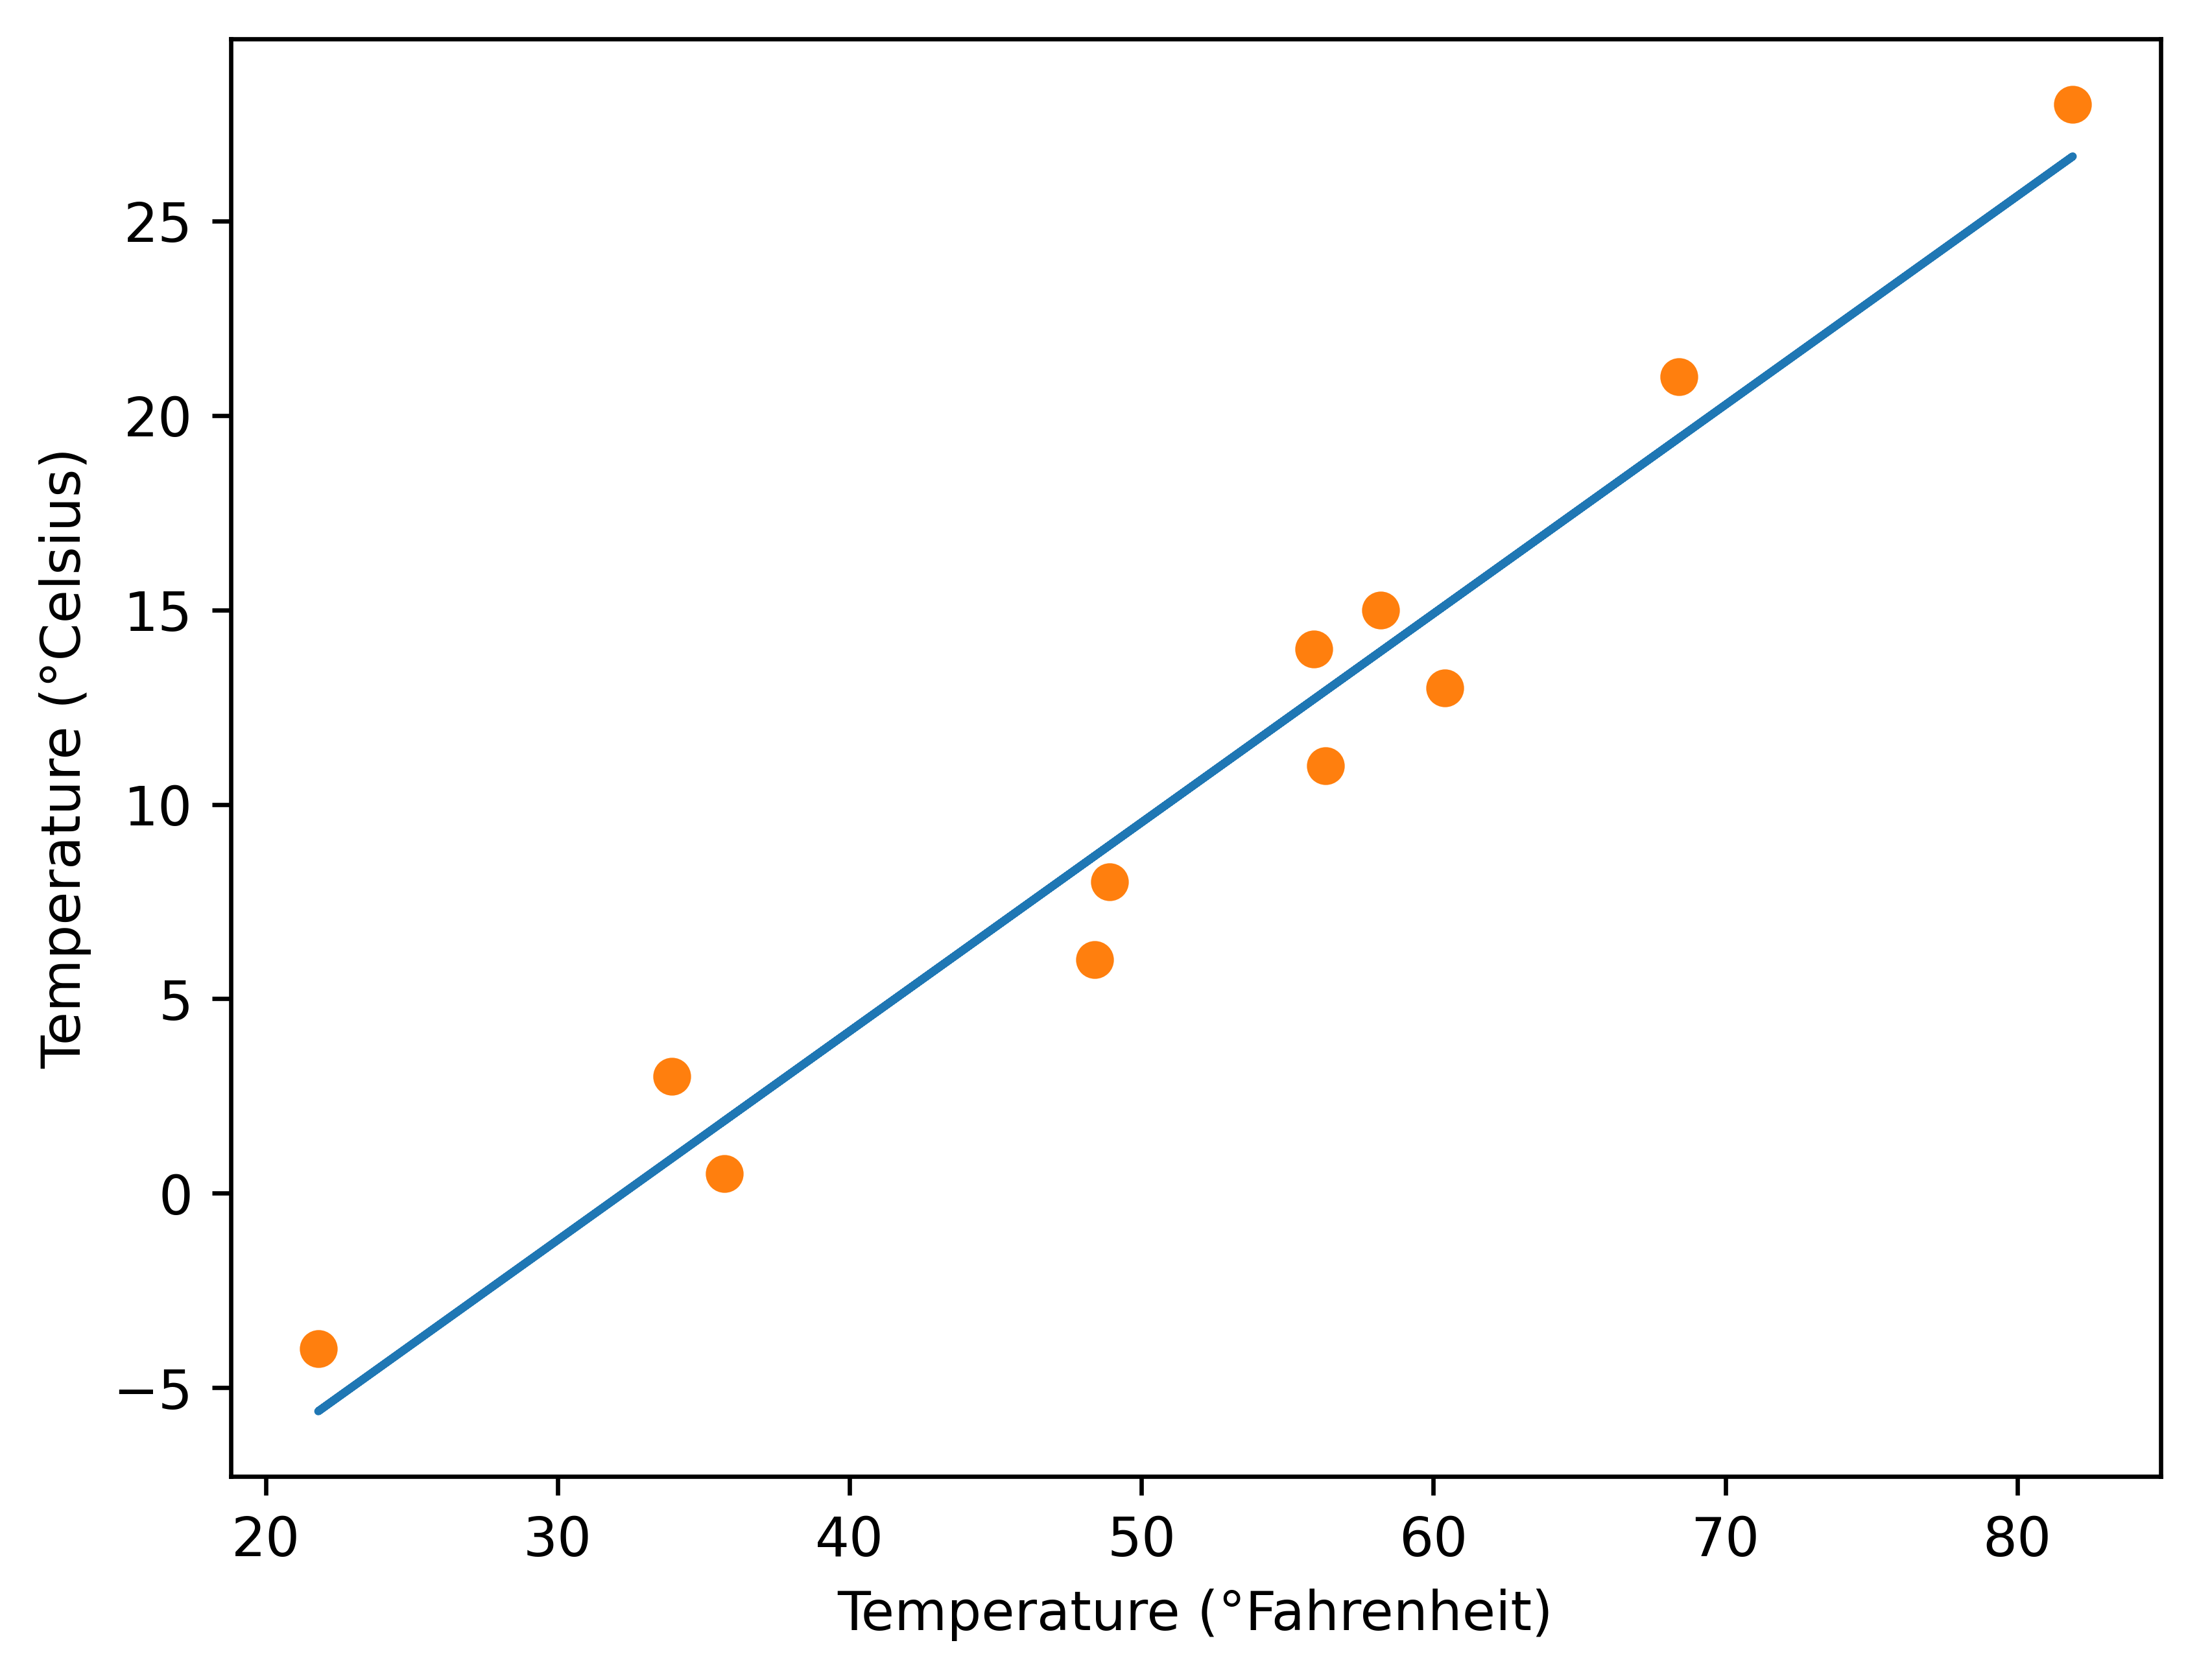

In [67]:
#Unpacking: model(t_un,  *params)  is  equivalent  to model(t_un, params[0], params[1])
t_p = model(t_un, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

- requires_grad tells PyTorch to track the entire family tree of tensors results from operations on params
- Any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor
- Value of the derivative will be automatically populated as a grad attribute of the params tensor

In [87]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
params.grad is None

True

In [88]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

- Calling backward() will lead derivatives to accumulate at leaf nodes. So if backward() was called earlier, the loss is evaluated again, backward() is called again, and the gradient at each leaf is accumulated (summed) on top of the one computed at the previous iteration, which leads to an incorrect value for the gradient

In [91]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
	for epoch in range(1, n_epochs + 1):
		# This can be done at any point in the loop prior to calling loss.backward()
		if params.grad is not None:
			params.grad.zero_()
		
		t_p = model(t_u, *params)
		loss = loss_fn(t_p, t_c)
		loss.backward()

		# Telling autograd to not add edges to the forward graph
		# Forward graph is consumed when we call backward(), leaving us with the params leaf node
		# We want to change this leaf node before we start building a fresh forward graph on top of it
		with torch.no_grad():
			params -= learning_rate * params.grad
		
		if epoch % 500 == 0:
			print('Epoch %d, Loss %f' % (epoch, float(loss)))
	
	return params

In [92]:
training_loop(
	n_epochs = 5000,
	learning_rate = 1e-2,
	params = torch.tensor([1.0, 0.0], requires_grad=True),
	t_u = t_un,
	t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers
- takes a list of parameters (typically with requires_grad set to True) as the first input
- All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access
  their grad attribute

In [114]:
import torch.optim as optim

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [115]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [116]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [117]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
	for epoch in range(1, n_epochs + 1):
		t_p = model(t_u, *params)
		loss = loss_fn(t_p, t_c)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if epoch % 500 == 0:
			print('Epoch %d, Loss %f' % (epoch, float(loss)))
			
	return params

In [118]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [119]:
training_loop(
	n_epochs = 5000,
	optimizer = optimizer,
	params = params,                           
	t_u = t_un,
	t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [120]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
# Adam: learning rate is set adaptively and is a lot less sensitive to the scaling of parameters so we can use the non-normalized input
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
	n_epochs = 2000,
	optimizer = optimizer,
	params = params,
	t_u = t_u,
	t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

- if the training loss is not decreasing, chances are the model is too simple for the data or our data does not contain meaningful information that lets it explain the output
- if the validation loss does not decrease along with the training set, it means our model is improving its fit of the samples seen during training, but not generalizing to samples outside of this set
- if the training loss and validation loss diverge we are overfitting
- Overfitting solutions
  - add penalization terms to the loss function
  - add noise to the input samples to create artifical data points in between training samples
  - make a simpler model
- Increase size until it fits and then scale it down until it stops overfitting

In [124]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  0,  6,  4,  2,  7, 10,  5,  8]), tensor([3, 9]))

In [130]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [137]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
	for epoch in range(1, n_epochs + 1):
		# Create separate graphs for training and validation data
		train_t_p = model(train_t_u, *params)
		train_loss = loss_fn(train_t_p, train_t_c)

		val_t_p = model(val_t_u, *params)          
		val_loss = loss_fn(val_t_p, val_t_c)

		# no val_loss.backward() since we don't want to train the model on the validation data
		# If we did call val_loss.backward, it would lead to the gradients accumlation in the params tensor on top of those generated
		# during train.loss_backward() and we would be training the model on the entire dataset
		optimizer.zero_grad()
		train_loss.backward()
		optimizer.step()

		if epoch <= 3 or epoch % 500 == 0:
			print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}," f" Validation loss {val_loss.item():.4f}")
	return params

In [135]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [136]:
training_loop(
	n_epochs = 3000,
	optimizer = optimizer,
	params = params,
	train_t_u = train_t_un,
	val_t_u = val_t_un,    
	train_t_c = train_t_c,
	val_t_c = val_t_c)

Epoch 1, Training loss 49.2367, Validation loss 220.4388
Epoch 2, Training loss 30.5863, Validation loss 130.6718
Epoch 3, Training loss 26.0094, Validation loss 96.0193
Epoch 500, Training loss 7.8411, Validation loss 21.0436
Epoch 1000, Training loss 3.9867, Validation loss 8.7093
Epoch 1500, Training loss 3.1084, Validation loss 5.2518
Epoch 2000, Training loss 2.9083, Validation loss 4.1551
Epoch 2500, Training loss 2.8627, Validation loss 3.7578
Epoch 3000, Training loss 2.8523, Validation loss 3.5969


tensor([  5.2167, -16.4868], requires_grad=True)